In [7]:
import os
import gc
import json
import pickle as pk
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch.cuda import empty_cache

from tqdm import tqdm

from CrabNet.kingcrab import CrabNet
from CrabNet.model import Model
from CrabNet.get_compute_device import get_compute_device

from sklearn.metrics import mean_absolute_error as mae, \
                            r2_score as r2, \
                            accuracy_score as acc, \
                            matthews_corrcoef as mcc,\
                            mean_squared_error as mse

compute_device = get_compute_device()

In [8]:
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# 全局设置字体及大小，设置公式字体即可，若要修改刻度字体，可在此修改全局字体
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,# 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 #分辨率

In [9]:
df = pd.read_csv('./data/data.csv', index_col=0)
df['is_metal'] = df['target'].map(lambda x: 1 if x==0 else 0)
df['is_metal'].value_counts()

0    70216
1    64037
Name: is_metal, dtype: int64

In [10]:
# 查看nan与inf
# 假设数据存储在变量中
# 检查是否包含NaN和inf
has_nan = np.isnan(df['target']).any()
has_inf = np.isinf(df['target']).any()
# 输出检查结果
if has_nan:
    print("数据中存在NaN")
else:
    print("数据中没有NaN")

if has_inf:
    print("数据中存在无穷大")
else:
    print("数据中没有无穷大")

数据中没有NaN
数据中没有无穷大


In [11]:
df['index'] = df.index
spinels = pd.read_csv('./data/spinel_oxides.csv')
spinels = spinels[['formula_pretty','spacegroup_number','band_gap','is_gap_direct']]
spinels.columns = ['formula','spacegroup','GGA','is_gap_direct']
spinels['index'] = spinels.index
spinels = pd.merge(spinels,df , on=['formula','spacegroup'], how='inner')

In [12]:
spinels

,formula,spacegroup,GGA_x,is_gap_direct,index_x,GGA_y,target,is_metal,index_y
0,NaMn2O4,227,0.0000,False,0,0.0000,0.000000,1,131
1,Cd(RhO2)2,227,0.8367,False,1,0.8367,2.470591,0,125609
2,CaIn2O4,227,2.0208,True,2,2.0208,3.393936,0,81767
3,Si(NiO2)2,227,3.5770,True,3,3.5770,3.577000,0,843
4,Mg2FeO4,227,0.0000,False,4,0.0000,0.000000,1,363
...,...,...,...,...,...,...,...,...,...
165,MgCr2O4,227,2.5264,True,165,2.5264,2.526400,0,27914
166,Mg(RhO2)2,227,1.1521,False,166,1.1521,3.042557,0,129217
167,LiV2O4,227,0.0000,False,167,0.0000,0.000000,1,28026
168,MnAl2O4,227,2.6578,True,168,2.6578,2.657800,0,28051


In [13]:
df = df.drop(index=spinels['index_y'])
df = df.reset_index(drop=True)
spinels = spinels[['formula','spacegroup','GGA_x','target','is_gap_direct']]
spinels.columns = ['formula','spacegroup','GGA','target','is_gap_direct']
df = df.dropna()


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters

fold_0
MAE: 0.4126126438429607
R2: 0.8241776048425564
RMSE: 0.8586749702318922

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters

fold_1
MAE: 0.42862498740804744
R2: 0.8071591509638449
RMSE: 0.8966244246326645

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters

fold_2
MAE: 0.4193648131241682
R2: 0.8167527892763724
RMSE: 0.8735316257430533

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters

fold_3
MAE: 0.41856611799815974
R2: 0.81295185167292
RMSE: 0.8831267708067826

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 87134/87134 [00:01<00:00, 80829.17formulae/s] 


loading data with up to 9 elements in the formula


Generating EDM: 100%|██████████| 26816/26816 [00:00<00:00, 227261.98formulae/s]


loading data with up to 9 elements in the formula
stepping every 3410 training passes, cycling lr every 10 epochs
checkin at 20 epochs to match lr scheduler
0
Epoch: 0/1000 --- train mae: 0.939 val mae: 0.974
1
2
3
4
5
10
11
13
15
16
19
Epoch: 19/1000 --- train mae: 0.373 val mae: 0.483
36
37
38
39
Epoch: 39/1000 --- train mae: 0.314 val mae: 0.457
59
Epoch: 59/1000 --- train mae: 0.27 val mae: 0.447
77
78
79
Epoch: 79/1000 --- train mae: 0.238 val mae: 0.438
99
Epoch: 99/1000 --- train mae: 0.21 val mae: 0.433
119
Epoch: 119/1000 --- train mae: 0.19 val mae: 0.43
139
Epoch: 139/1000 --- train mae: 0.175 val mae: 0.427
159
Epoch: 159/1000 --- train mae: 0.161 val mae: 0.426
179
Epoch: 179/1000 --- train mae: 0.148 val mae: 0.426
199
Epoch: 199/1000 --- train mae: 0.14 val mae: 0.426
219
Epoch: 219/1000 --- train mae: 0.131 val mae: 0.423
Epoch: 239/1000 --- train mae: 0.127 val mae: 0.424
Epoch: 259/1000 --- train mae: 0.12 val mae: 0.424
Epoch: 279/1000 --- train mae: 0.118 val mae: 0

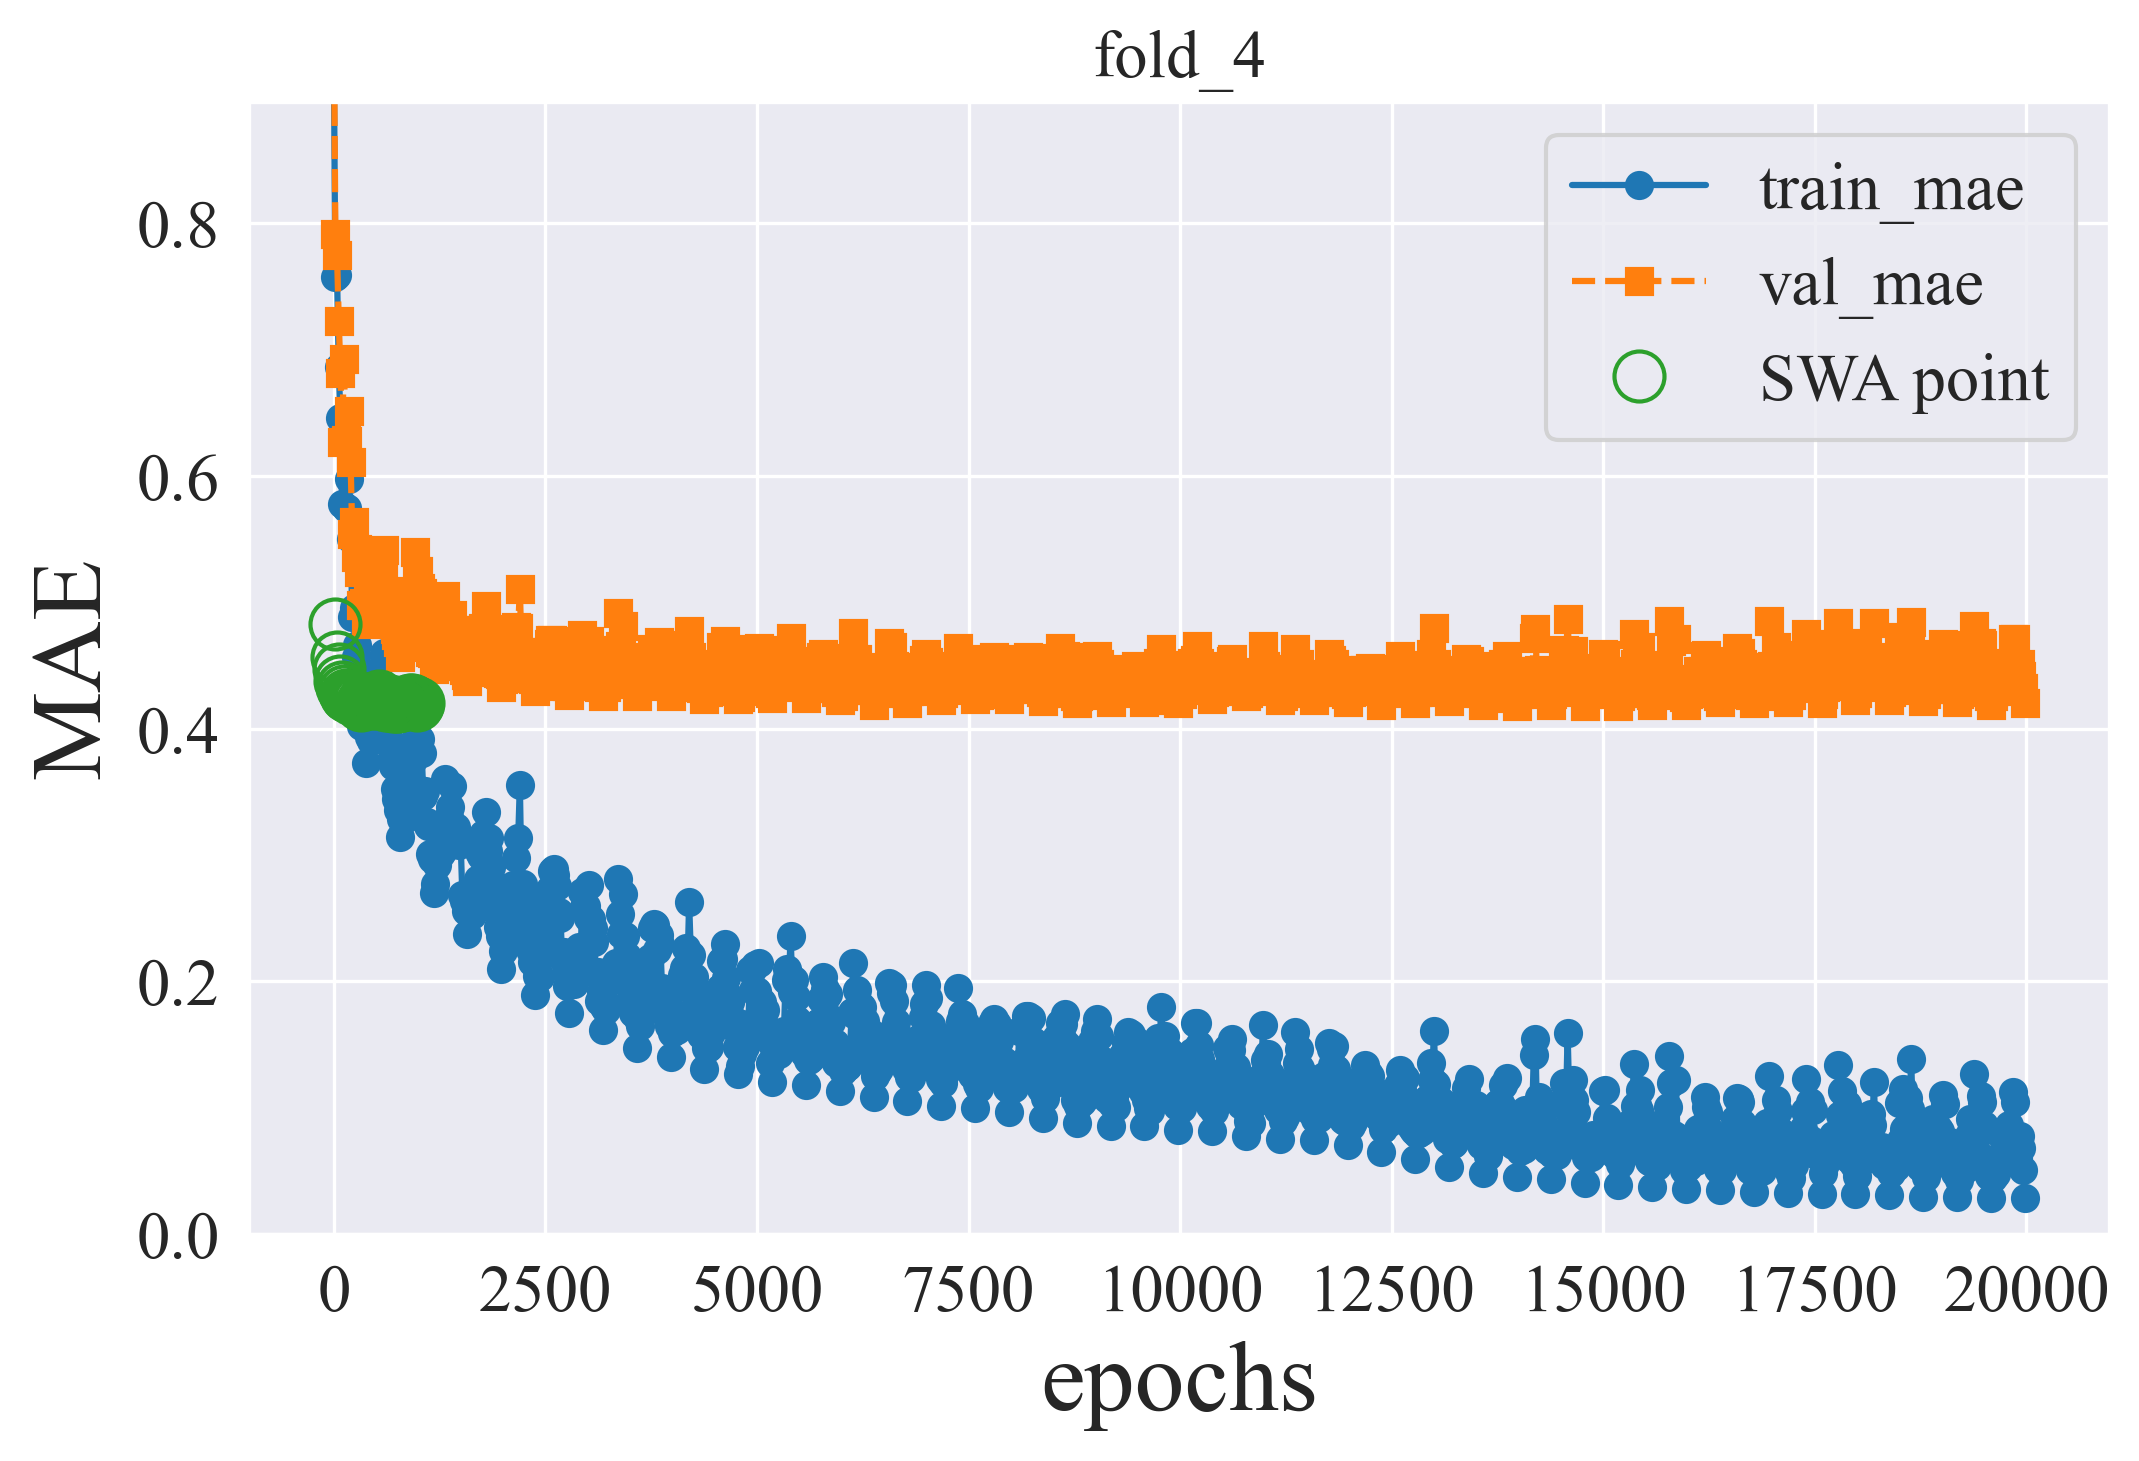

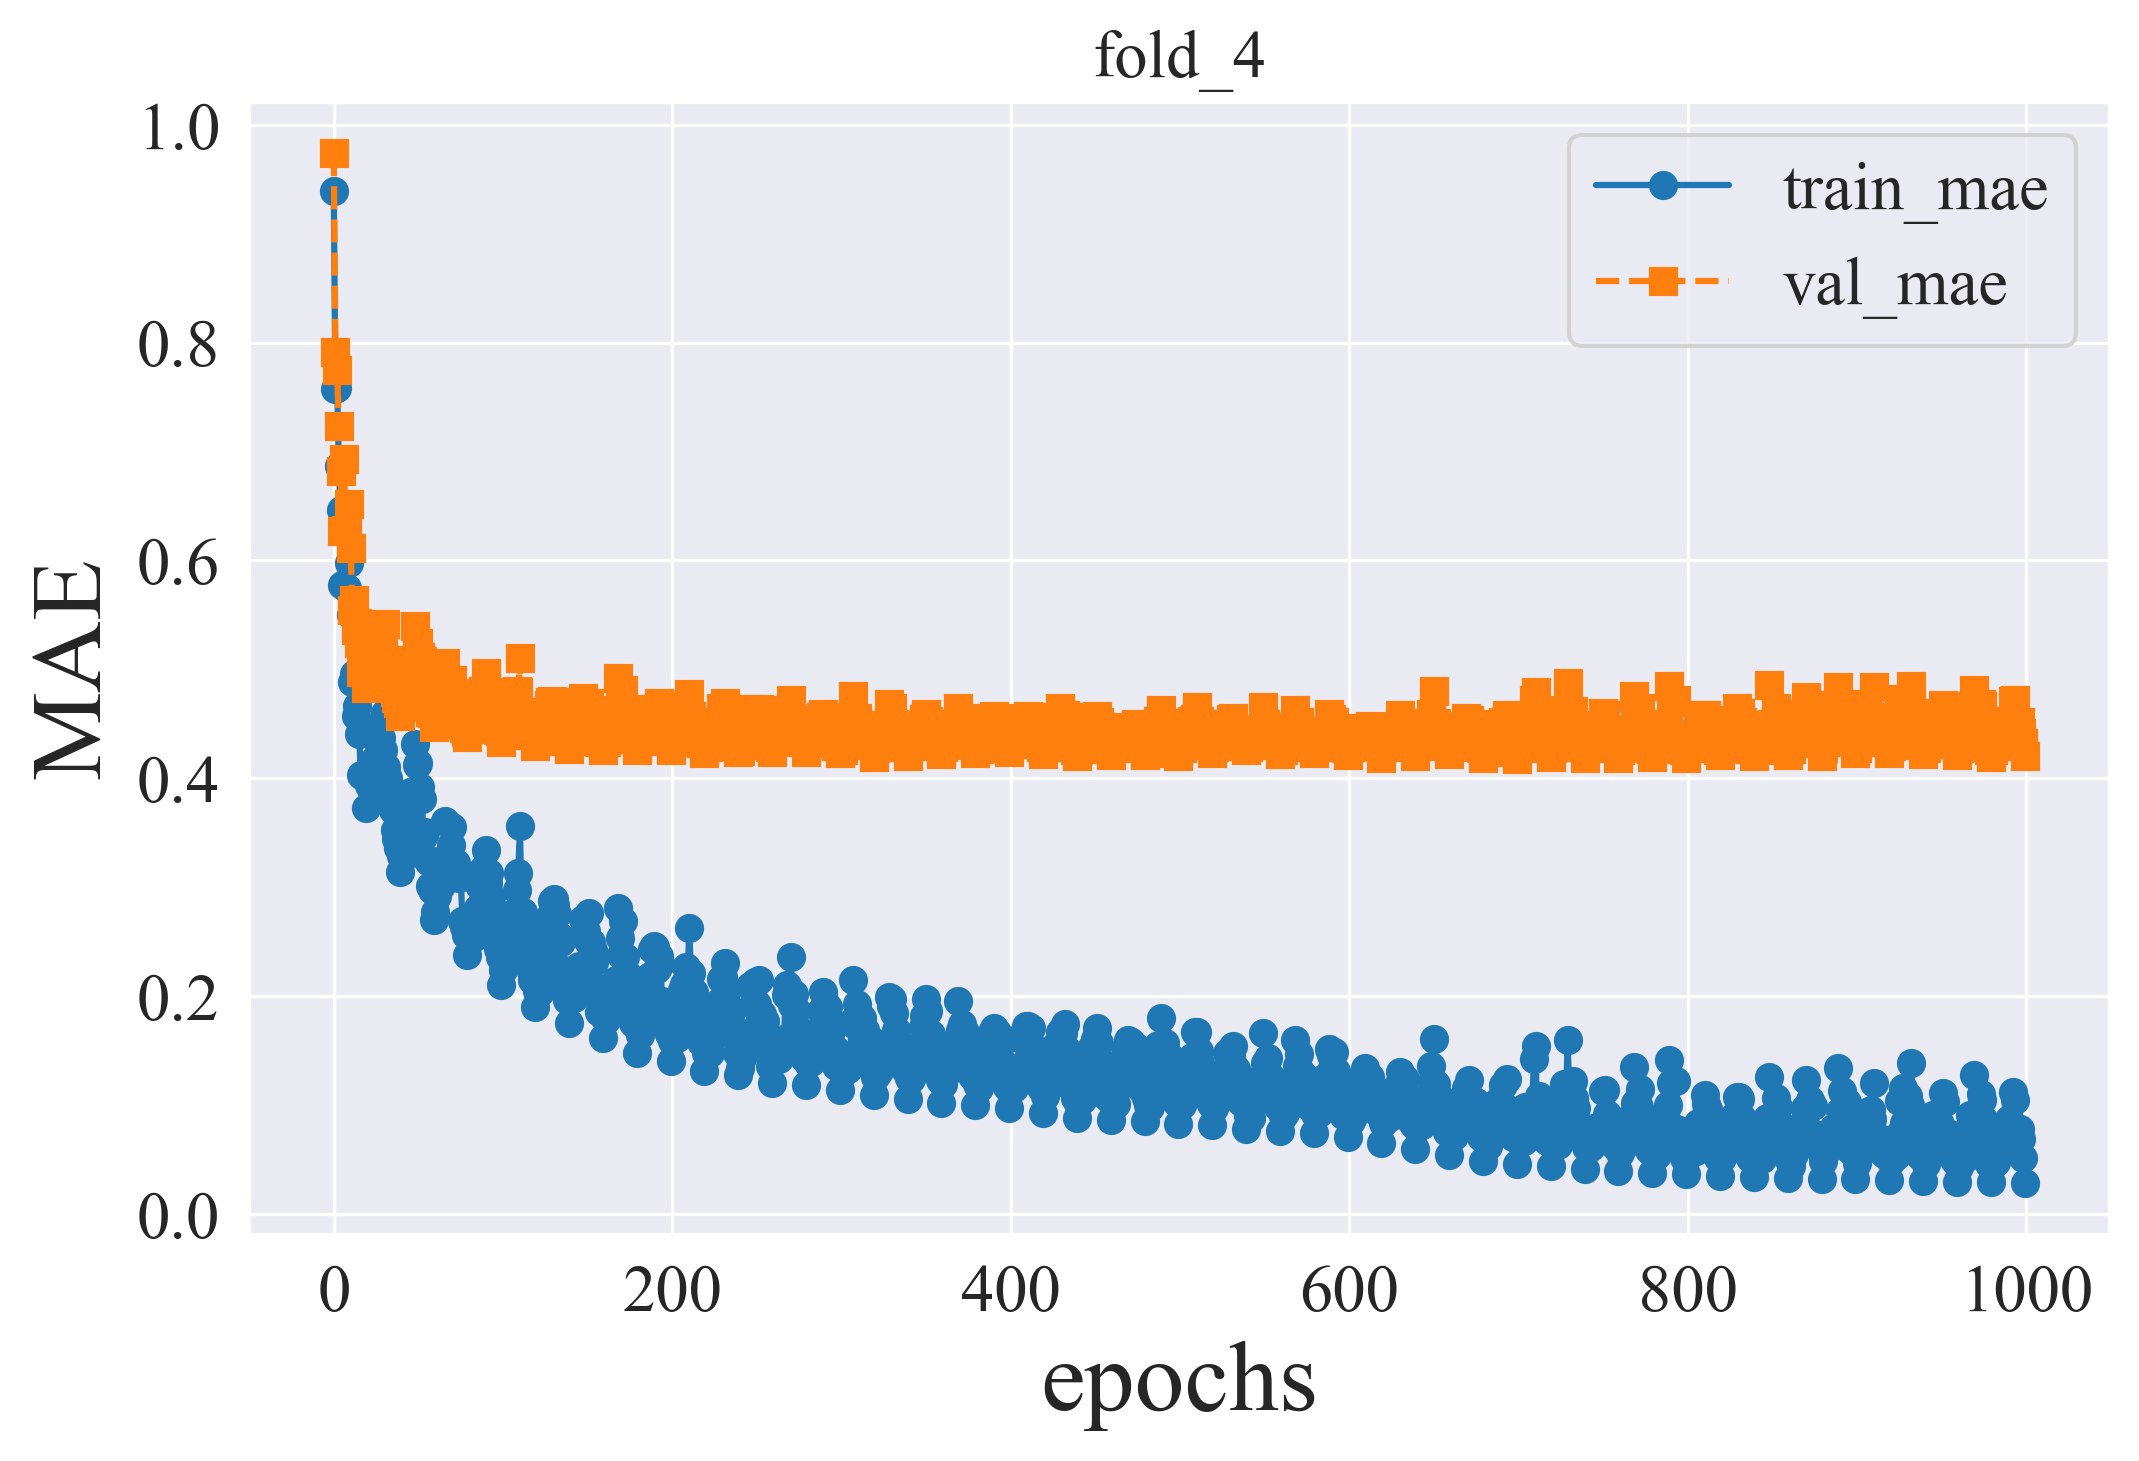


fold_4
MAE: 0.41782671587428205
R2: 0.8165702355300927
RMSE: 0.873059200019319
Saving checkpoint (fold_4.pth) to models/trained_models/fold_4.pth


In [14]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_indices = kf.split(df["formula"], df["is_metal"])
for i, (train_index, val_index) in enumerate(cv_indices):
    train, val = df.loc[train_index], df.loc[val_index]
    name = f"fold_{i}"
    model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      model_name=name, verbose=True, classification=False)
    if os.path.exists(f'./result/predictions_crabnet/{name}.csv'):
        res_df = pd.read_csv(f'./result/predictions_crabnet/{name}.csv')
        print(name)
        print(f"MAE: {mae(res_df['real'], res_df['pred'])}")
        print(f"R2: {r2(res_df['real'], res_df['pred'])}")
        print(f"RMSE: {np.sqrt(mse(res_df['real'], res_df['pred']))}")
    else:
        model.load_data(train, train=True)
        model.load_data(val)
        model.fit(epochs=1000, losscurve=True)
        res = model.best_results
        res_df = pd.DataFrame({"composition": res[2], "real": res[0], "pred": res[1], 'uncert':res[3]})
        print(name)
        print(f"MAE: {mae(res_df['real'], res_df['pred'])}")
        print(f"R2: {r2(res_df['real'], res_df['pred'])}")
        print(f"RMSE: {np.sqrt(mse(res_df['real'], res_df['pred']))}")
        res_df.to_csv(f'./result/predictions_crabnet/{name}.csv',index=False)
        model.save_network(f'{name}.pth')


In [15]:
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      verbose=True, classification=False)
best_mae = 1
best_fold = 0
for i in range(0,5):
    model.load_network(f'./models/trained_models/fold_{i}.pth')
    real = spinels['target']
    model.load_data(spinels)
    pred  = model.predict(model.data_loader)[1]
    print(f"MAE: {mae(real, pred)}")
    print(f"R2: {r2(real, pred)}")
    print(f"RMSE: {np.sqrt(mse(real, pred))}")
    tmp_mae = mae(real, pred)
    if tmp_mae < best_mae:
        best_mae = tmp_mae
        best_fold = i


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 169971.79formulae/s]


loading data with up to 3 elements in the formula
MAE: 0.5640525328037979
R2: 0.7807171265745727
RMSE: 0.8504893287326796


Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 170093.44formulae/s]

loading data with up to 3 elements in the formula
MAE: 0.5856051099036912
R2: 0.7636907812500573
RMSE: 0.8828905009813719



Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 169971.79formulae/s]


loading data with up to 3 elements in the formula
MAE: 0.5617075545434742
R2: 0.765892317858976
RMSE: 0.8787682241194383


Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 84915.05formulae/s]


loading data with up to 3 elements in the formula
MAE: 0.5483919502210425
R2: 0.7920445455247209
RMSE: 0.8282313591272147


Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 169688.64formulae/s]

loading data with up to 3 elements in the formula
MAE: 0.5760956005869012
R2: 0.7720132732830615
RMSE: 0.8672040426043397
